### Practical Lab 3 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

<div style="display: flex; flex-wrap: wrap; gap: 10px;">
    <div style="border: 1px solid #ddd; border-radius: 5px; padding: 10px; width: 400px;">
        <h4>Dheeraj Choudhary</h4>
        <p><h4>ID: 9014533<h4></p>
</div>

The dataset is obtained from:
* [Dogs versus Cats](https://www.kaggle.com/c/dogs-vs-cats) - The Kaggle competition

> ### The Asirra data set
>Web services are often protected with a challenge that's supposed to be easy for people to solve, but difficult for computers. Such a challenge is often called a CAPTCHA (Completely Automated Public Turing test to tell Computers and Humans Apart). CAPTCHAs are used for many purposes, such as to reduce email and blog spam and prevent brute-force attacks on web site passwords.

>Asirra (Animal Species Image Recognition for Restricting Access) is a CAPTCHA that works by asking users to identify photographs of cats and dogs. This task is difficult for computers, but studies have shown that people can accomplish it quickly and accurately. Many even think it's fun! Here is an example of the Asirra interface:

>Asirra is unique because of its partnership with Petfinder.com, the world's largest site devoted to finding homes for homeless pets. They've provided Microsoft Research with over three million images of cats and dogs, manually classified by people at thousands of animal shelters across the United States. Kaggle is fortunate to offer a subset of this data for fun and research. 

### Importing Libraries

In [ ]:
import os, shutil, pathlib
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

### Preparing Dataset Subsets for Training, Validation, and Testing  

This code checks for a specific file, creates directories, and organizes the **Dogs vs Cats** dataset by dividing it into **training, validation, and test subsets** using predefined indices. It ensures the subsets are structured properly for model training and evaluation.


In [6]:
file_path = "kaggle_dogs_vs_cats/train/cat"
if os.path.exists(file_path):
    # Handle the existing file, e.g., overwrite, append, or skip
    print(f"File {file_path} already exists.")
else:
    # Create the file
    with open(file_path, 'w') as f:
        # Write to the file
        f.write("Your content here")

import os, shutil, pathlib

original_dir = pathlib.Path("kaggle_dogs_vs_cats/train")
new_base_dir = pathlib.Path("kaggle_dogs_vs_cats_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

File kaggle_dogs_vs_cats/train/cat already exists.


## EDA: Explore the data with relevant graphs, statistics and insights

### Display count of images in each subset for [Training, Validation, Test]

In [65]:
# Paths to the subsets
base_dir = "kaggle_dogs_vs_cats_small"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

# Function to count images in each subset
def count_images(directory):
    counts = {}
    for category in os.listdir(directory):
        category_dir = os.path.join(directory, category)
        counts[category] = len(os.listdir(category_dir))
    return counts

# Count images in each subset
train_counts = count_images(train_dir)
validation_counts = count_images(validation_dir)
test_counts = count_images(test_dir)

# Display counts
print("Training Data Distribution:", train_counts)
print("Validation Data Distribution:", validation_counts)
print("Test Data Distribution:", test_counts)

Training Data Distribution: {'cat': 1000, 'dog': 1000}
Validation Data Distribution: {'cat': 500, 'dog': 500}
Test Data Distribution: {'cat': 1000, 'dog': 1000}


### Visualize Data distribution across training, validation and test subsets

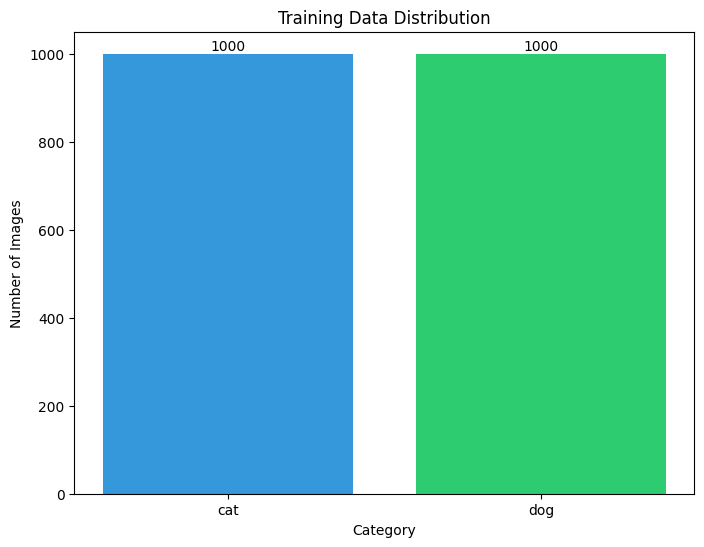

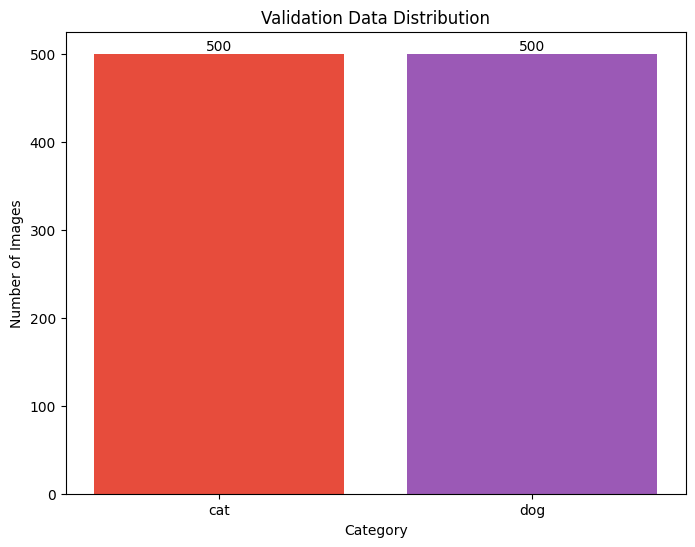

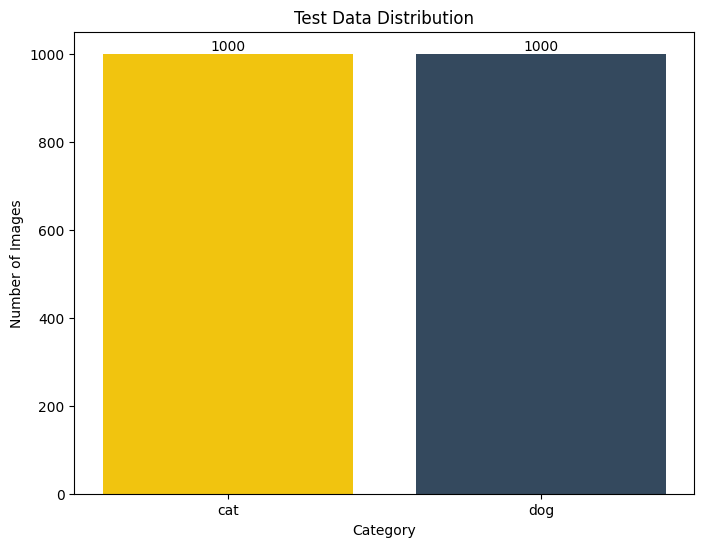

In [66]:
# Plotting Data Distribution (Fixed for FutureWarning)
def plot_distribution(data, title, bar_colors):
    plt.figure(figsize=(8, 6))
    bars = plt.bar(list(data.keys()), list(data.values()), color=bar_colors)
    for bar, count in zip(bars, list(data.values())):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f"{count}", ha="center", va="bottom", fontsize=10, color="black")
    plt.title(title)
    plt.ylabel("Number of Images")
    plt.xlabel("Category")
    plt.show()

# Customize bar colors for each graph
train_colors = ["#3498db", "#2ecc71"]
validation_colors = ["#e74c3c", "#9b59b6"]
test_colors = ["#f1c40f", "#34495e"]

# Plot distributions
plot_distribution(train_counts, "Training Data Distribution", train_colors)
plot_distribution(validation_counts, "Validation Data Distribution", validation_colors)
plot_distribution(test_counts, "Test Data Distribution", test_colors)

### Visualizing Sample Images 

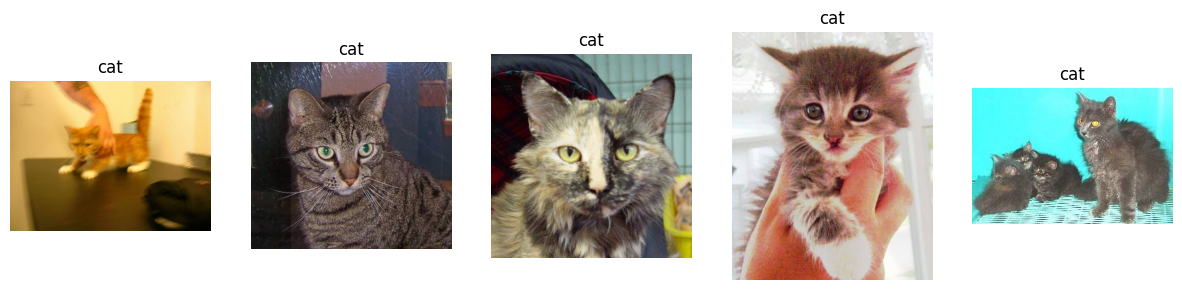

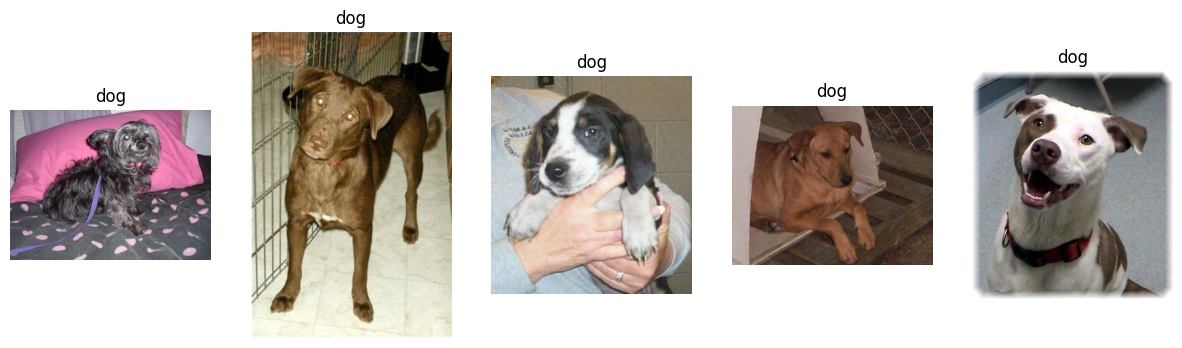

In [67]:
# Visualizing Sample Images
def visualize_images(directory, category, num_images=5):
    category_dir = os.path.join(directory, category)
    file_names = os.listdir(category_dir)[:num_images]
    plt.figure(figsize=(15, 5))
    for i, fname in enumerate(file_names):
        img = Image.open(os.path.join(category_dir, fname))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(category)
    plt.show()

# Visualize sample images from the training set
visualize_images(train_dir, "cat", num_images=5)
visualize_images(train_dir, "dog", num_images=5)

### Image Size Analysis Visualization

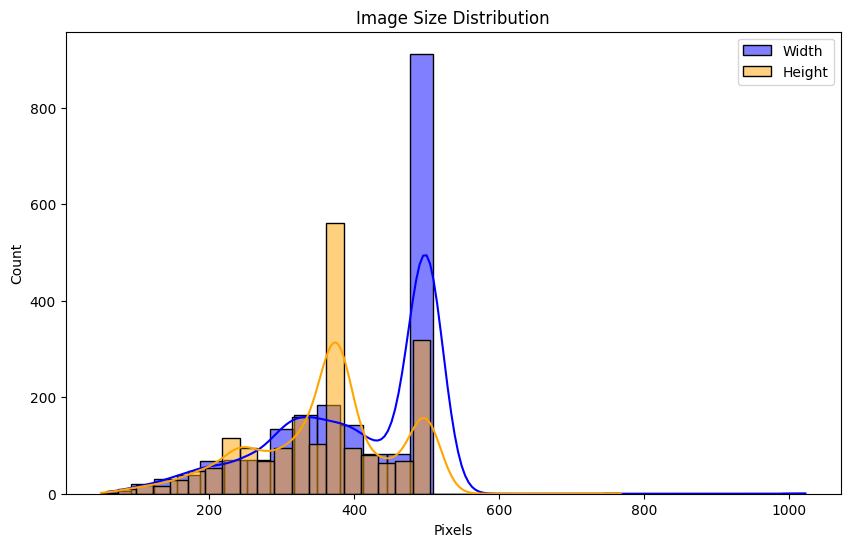

In [68]:
# Image Size Analysis
def image_size_analysis(directory):
    sizes = []
    for category in os.listdir(directory):
        category_dir = os.path.join(directory, category)
        for fname in os.listdir(category_dir):
            img = Image.open(os.path.join(category_dir, fname))
            sizes.append(img.size)
    return sizes

train_sizes = image_size_analysis(train_dir)
widths, heights = zip(*train_sizes)

# Plot Image Sizes
plt.figure(figsize=(10, 6))
sns.histplot(widths, bins=30, color="blue", label="Width", kde=True)
sns.histplot(heights, bins=30, color="orange", label="Height", kde=True)
plt.title("Image Size Distribution")
plt.xlabel("Pixels")
plt.legend()
plt.show()

### Image Size Statistics

In [69]:
# Display Basic Statistics
print(f"Average Image Width: {sum(widths) / len(widths):.2f}")
print(f"Average Image Height: {sum(heights) / len(heights):.2f}")
print(f"Most Common Image Size: {Counter(train_sizes).most_common(1)}")

Average Image Width: 403.97
Average Image Height: 358.92
Most Common Image Size: [((500, 374), 226)]


## Define a Neural Network of Your Choice

**Summary:** We create a custom Convolutional Neural Network (CNN) using layers such as convolution, pooling, dropout, and fully connected layers. This model is compiled and trained on the dataset to classify images as either cats or dogs.
1. **Data Loading**: Images are loaded and preprocessed using `image_dataset_from_directory` with resizing and normalization.
2. **Model Architecture**: The CNN consists of 5 convolutional layers, max-pooling, flattening, and a dense output layer for binary classification.
3. **Compilation & Training**: The model uses the RMSprop optimizer and binary cross-entropy loss. It is trained with a `ModelCheckpoint` callback to save the best model based on validation loss.
4. **Evaluation**:
   - **Accuracy**: The model's accuracy is evaluated on the test dataset.
   - **Confusion Matrix**: A confusion matrix is generated to show the true vs. predicted classifications.
   - **Precision, Recall, F1-Score**: Precision, recall, and F1-score are calculated to assess classification performance.
   - **Precision-Recall Curve**: The precision-recall curve is plotted to evaluate model performance in imbalanced class situations.
   - **Failure Case Analysis**: Specific examples where the model failed to predict correctly are explored and displayed.


Load the data into three sets:

In [70]:
data_folder = pathlib.Path('kaggle_dogs_vs_cats_small')

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


**Model Architecture:** The CNN consists of 5 convolutional layers, max-pooling, flattening, and a dense output layer for binary classification

In [71]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                      

**Compilation & Training:** The model uses the RMSprop optimizer and binary cross-entropy loss. It is trained with a ModelCheckpoint callback to save the best model based on validation loss.

In [72]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 33s 510ms/step - loss: 0.7095 - accuracy: 0.5145 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 32s 514ms/step - loss: 0.6924 - accuracy: 0.5345 - val_loss: 0.6921 - val_accuracy: 0.5020
Epoch 3/30
63/63 [==============================] - 32s 509ms/step - loss: 0.6901 - accuracy: 0.5610 - val_loss: 0.6710 - val_accuracy: 0.6100
Epoch 4/30
63/63 [==============================] - 31s 499ms/step - loss: 0.7006 - accuracy: 0.6195 - val_loss: 0.6487 - val_accuracy: 0.6310
Epoch 5/30
63/63 [==============================] - 32s 503ms/step - loss: 0.6256 - accuracy: 0.6530 - val_loss: 0.6108 - val_accuracy: 0.6720
Epoch 6/30
63/63 [==============================] - 32s 514ms/step - loss: 0.6025 - accuracy: 0.6840 - val_loss: 1.0035 - val_accuracy: 0.5580
Epoch 7/30
63/63 [==============================] - 34s 542ms/step - loss: 0.5591 - accuracy: 0.7210 - val_loss: 1.1676 - val_accuracy: 0.5800

## Relative performance of the models

Plotting accuracy and loss

63/63 [==============================] - 6s 95ms/step - loss: 1.9605 - accuracy: 0.7360
Test Accuracy: 0.736


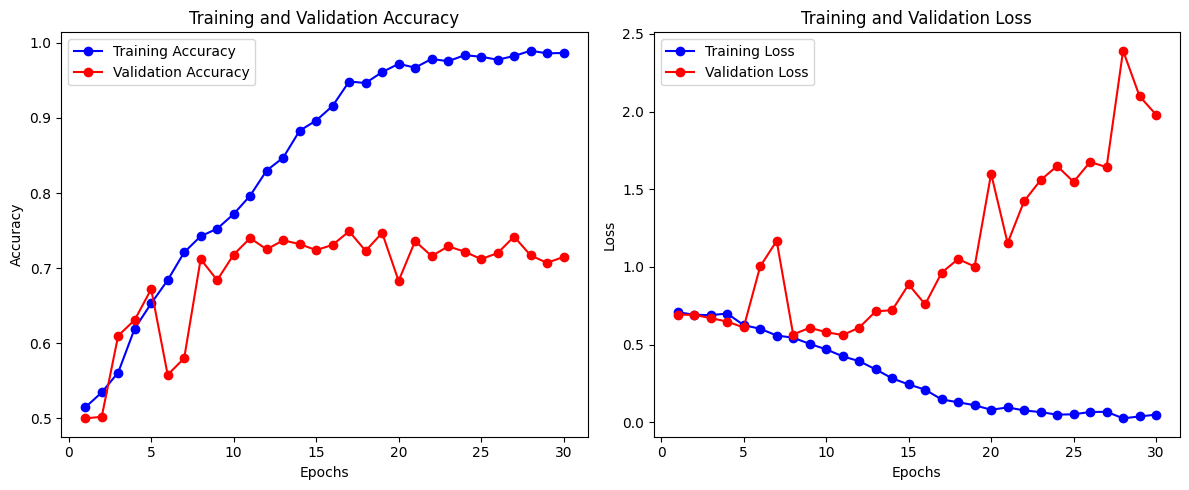

In [73]:
# Evaluate accuracy on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.3f}")

# Plot accuracy and loss (assuming `history` object from model training is available)
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "bo-", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "ro-", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo-", label="Training Loss")
plt.plot(epochs, val_loss, "ro-", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

Confusion Matrix

63/63 [==============================] - 6s 96ms/step


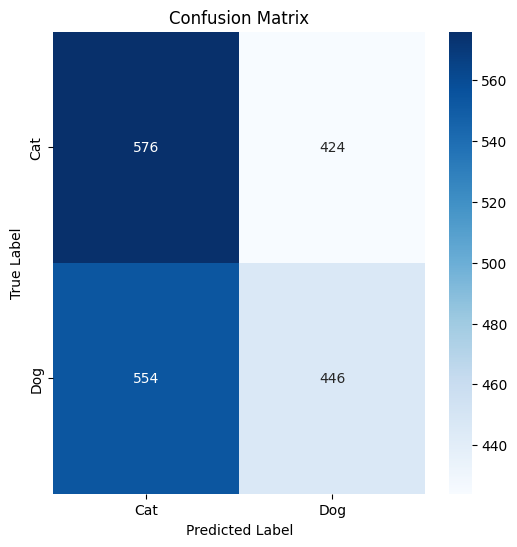

In [74]:
# Predict on the test dataset
y_pred = model.predict(test_dataset)
y_pred_class = np.round(y_pred)  # Convert probabilities to class labels (0 or 1)

# True labels for the test dataset
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Calculating Precision, Recall, and F1-Score

To evaluate classification performance:
1. **Precision**: Measures the proportion of correctly predicted positive cases out of all predicted positives.
2. **Recall**: Measures the proportion of correctly predicted positive cases out of all actual positives.
3. **F1-Score**: Harmonic mean of precision and recall, balancing both metrics.

These metrics provide insights into the model's accuracy and its handling of imbalanced datasets, helping to understand its predictive reliability.


Precision: 0.513
Recall: 0.446
F1 Score: 0.477


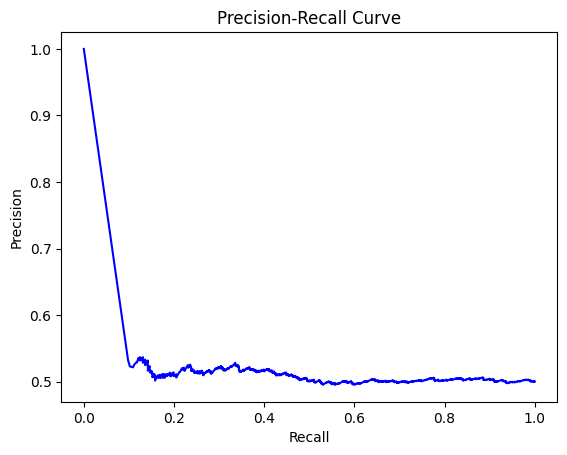

In [75]:
# Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred)
plt.plot(recall_vals, precision_vals, color='b')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Exploring Specific Examples Where the Model Failed to Predict Correctly

To identify misclassified examples:
1. **Compare Predictions with True Labels**: Locate indices where predicted classes (`y_pred_class`) do not match the true labels (`y_true`).
2. **Retrieve Misclassified Images**: Use these indices to fetch the corresponding images from the dataset.
3. **Visualize Misclassified Cases**: Display the images alongside their true labels and predicted labels for analysis.

This helps in understanding patterns in model errors and identifying areas for improvement.


Incorrect Predictions (indices): [   0    0    0 ... 1999 1999 1999]


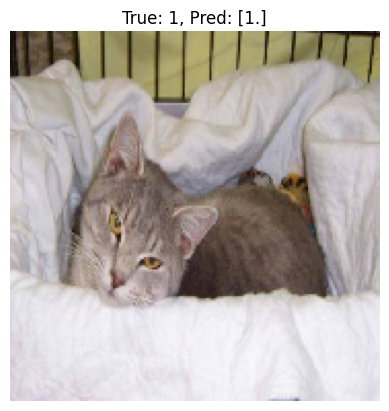

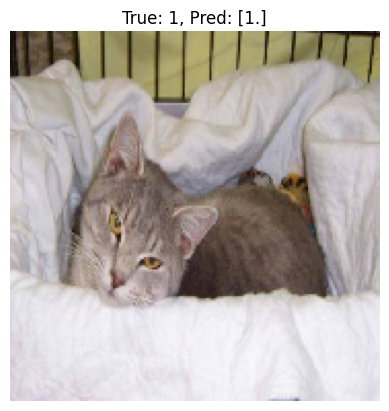

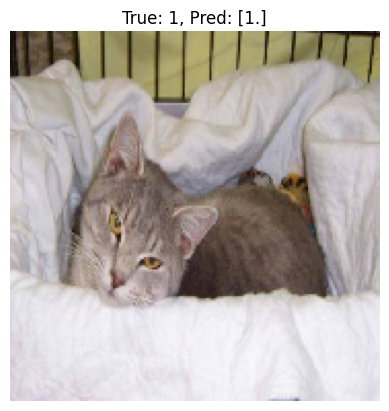

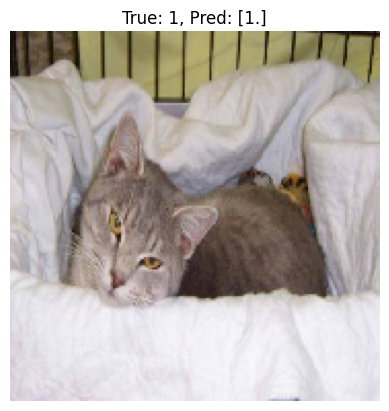

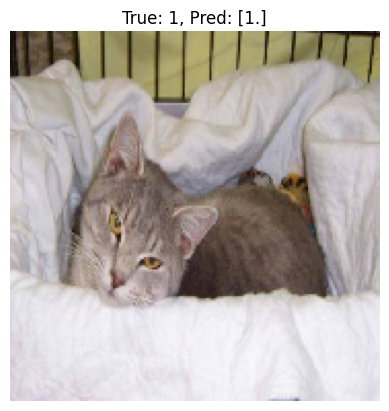

In [76]:
# Explore specific examples where the model failed to predict correctly
incorrect_preds = np.where(y_pred_class != y_true)[0]

print(f"Incorrect Predictions (indices): {incorrect_preds}")

# Display some incorrect predictions
for idx in incorrect_preds[:5]:  # Show top 5 incorrect predictions
    img_path = test_dataset.file_paths[idx]
    img = image.load_img(img_path, target_size=(180, 180))
    img_array = image.img_to_array(img) / 255.0
    plt.imshow(img_array)
    plt.title(f"True: {y_true[idx]}, Pred: {y_pred_class[idx]}")
    plt.axis('off')
    plt.show()


## VGG16 Fine-Tuning Approach

**Load Pre-trained VGG16**: Use the VGG16 model pre-trained on ImageNet as the base model.

In [78]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Load the dataset

In [79]:
data_folder = pathlib.Path('kaggle_dogs_vs_cats_small')

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


**Feature Extraction Using Pre-trained VGG16:** The code extracts features from the dataset using the pre-trained VGG16 convolutional base and prepares them along with their corresponding labels for training, validation, and testing.

In [80]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 563ms/step


**Defining the Classification Head for VGG16 Features**: The code defines a classification head for the VGG16 extracted features, flattening the input, adding dense layers with dropout, and outputting a binary classification result.

In [81]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 5, 5, 512)]       0         
                                                                 
 flatten_6 (Flatten)         (None, 12800)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               3277056   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3,277,313
Trainable params: 3,277,313
Non-trainable params: 0
_________________________________________________________________


**Compile and Train**: Compile the model with an appropriate loss function and optimizer, then train it on the new dataset with callbacks to save the best model version.

In [82]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="./models/feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 23ms/step - loss: 15.3875 - accuracy: 0.9205 - val_loss: 12.7891 - val_accuracy: 0.9180
Epoch 2/20
63/63 [==============================] - 1s 19ms/step - loss: 4.0149 - accuracy: 0.9735 - val_loss: 3.7423 - val_accuracy: 0.9780
Epoch 3/20
63/63 [==============================] - 1s 19ms/step - loss: 1.4272 - accuracy: 0.9870 - val_loss: 5.9061 - val_accuracy: 0.9690
Epoch 4/20
63/63 [==============================] - 1s 22ms/step - loss: 1.2041 - accuracy: 0.9920 - val_loss: 3.6843 - val_accuracy: 0.9730
Epoch 5/20
63/63 [==============================] - 1s 21ms/step - loss: 1.1342 - accuracy: 0.9905 - val_loss: 4.1975 - val_accuracy: 0.9790
Epoch 6/20
63/63 [==============================] - 1s 18ms/step - loss: 0.7539 - accuracy: 0.9940 - val_loss: 8.0287 - val_accuracy: 0.9650
Epoch 7/20
63/63 [==============================] - 1s 19ms/step - loss: 1.0132 - accuracy: 0.9930 - val_loss: 3.5956 - val_accuracy: 0.9830
Epoch 8/20


Plot accuracy and Loss

63/63 [==============================] - 0s 3ms/step - loss: 5.4181 - accuracy: 0.9745
VGG16 Test Accuracy: 0.975
63/63 [==============================] - 0s 3ms/step


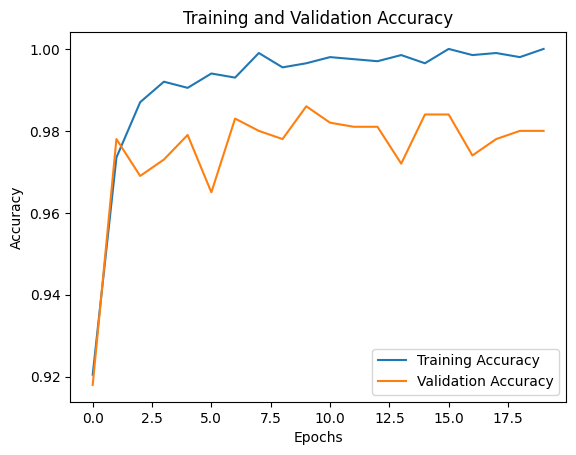

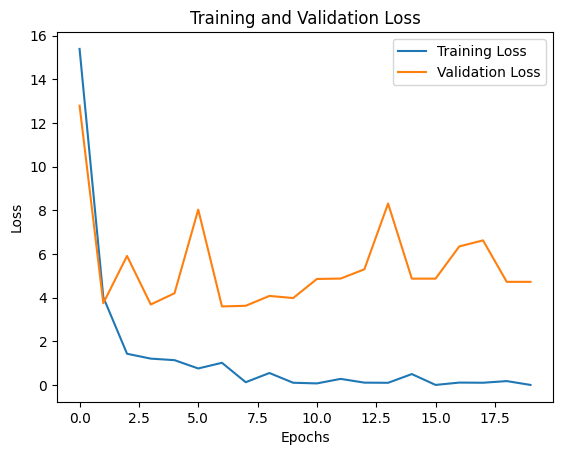

Final VGG16 Test Accuracy: 0.975


In [83]:
# Load the saved model (VGG16 based)
vgg16_model = keras.models.load_model("./models/feature_extraction.keras")

# Evaluate the VGG16 model on the test dataset
vgg16_test_loss, vgg16_test_acc = vgg16_model.evaluate(test_features, test_labels)
print(f"VGG16 Test Accuracy: {vgg16_test_acc:.3f}")

# Predictions for VGG16
vgg16_predictions = vgg16_model.predict(test_features)
vgg16_pred_class = (vgg16_predictions > 0.5).astype(int)  # Convert to binary class

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Display final test accuracy
print(f"Final VGG16 Test Accuracy: {vgg16_test_acc:.3f}")

Confusion Matrix for VGG16

VGG16 Confusion Matrix:
[[984  16]
 [ 35 965]]


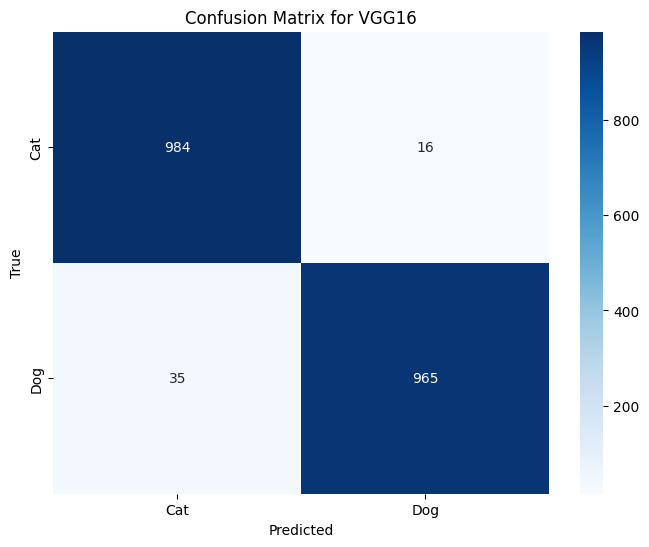

In [84]:
# Confusion Matrix for VGG16
vgg16_cm = confusion_matrix(test_labels, vgg16_pred_class)
print("VGG16 Confusion Matrix:")
print(vgg16_cm)

# Plotting Confusion Matrix for VGG16
plt.figure(figsize=(8, 6))
sns.heatmap(vgg16_cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title("Confusion Matrix for VGG16")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Calculating Precision, Recall, and F1-Score For VGG16

To evaluate classification performance:
1. **Precision**: Measures the proportion of correctly predicted positive cases out of all predicted positives.
2. **Recall**: Measures the proportion of correctly predicted positive cases out of all actual positives.
3. **F1-Score**: Harmonic mean of precision and recall, balancing both metrics.

These metrics provide insights into the model's accuracy and its handling of imbalanced datasets, helping to understand its predictive reliability.


Precision: 0.513
Recall: 0.446
F1 Score: 0.477


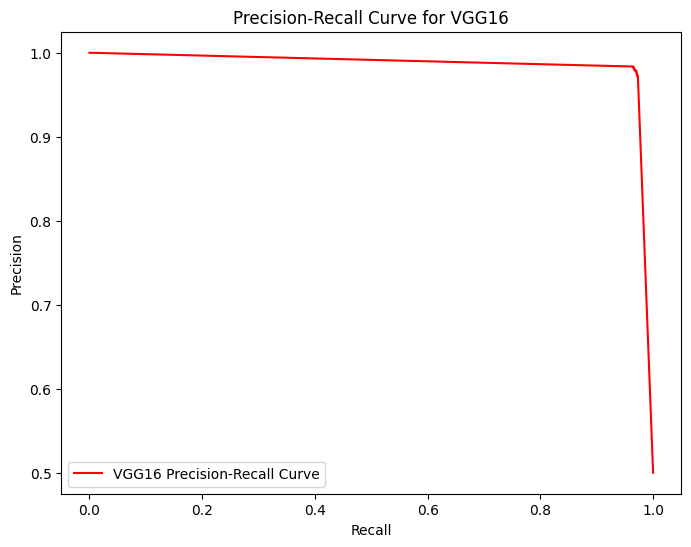

In [85]:
vgg16_precision = precision_score(test_labels, vgg16_pred_class)
vgg16_recall = recall_score(test_labels, vgg16_pred_class)
vgg16_f1 = f1_score(test_labels, vgg16_pred_class)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Plotting Precision-Recall Curve for VGG16
precision_vgg16, recall_vgg16, _ = precision_recall_curve(test_labels, vgg16_predictions)
plt.figure(figsize=(8, 6))
plt.plot(recall_vgg16, precision_vgg16, color='r', label='VGG16 Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for VGG16')
plt.legend()
plt.show()

Exploring Specific Examples Where the Model Failed to Predict Correctly for VGG16

To identify misclassified examples:
1. **Compare Predictions with True Labels**: Locate indices where predicted classes (`y_pred_class`) do not match the true labels (`y_true`).
2. **Retrieve Misclassified Images**: Use these indices to fetch the corresponding images from the dataset.
3. **Visualize Misclassified Cases**: Display the images alongside their true labels and predicted labels for analysis.

This helps in understanding patterns in model errors and identifying areas for improvement.


VGG16 Failed Predictions Indices: [   0    0    0 ... 1999 1999 1999]


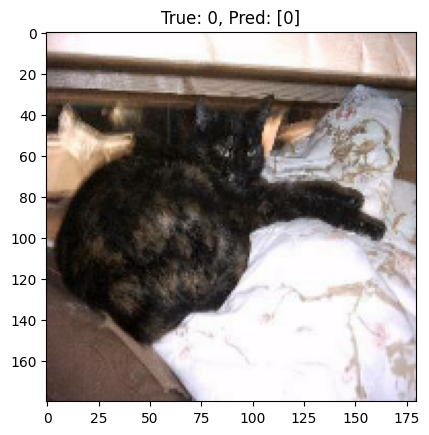

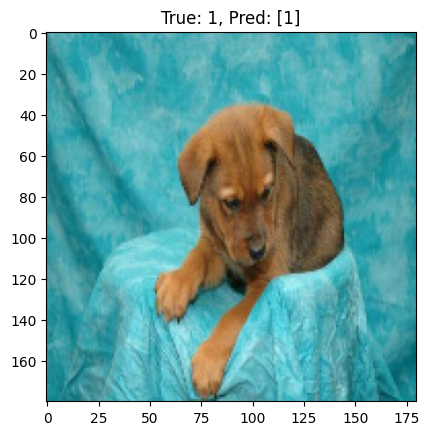

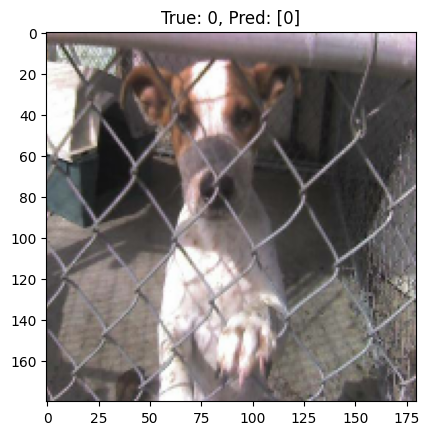

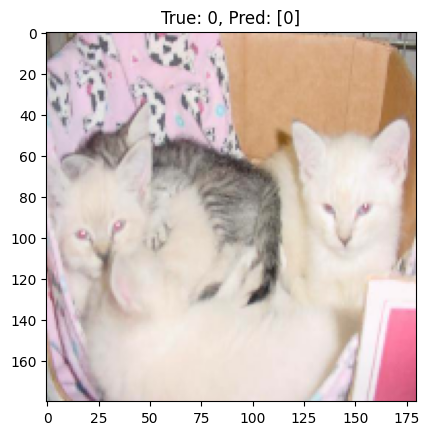

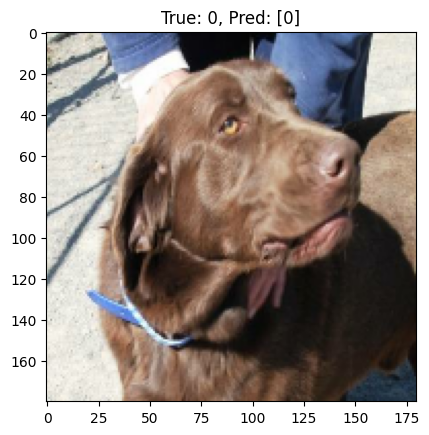

In [86]:
vgg16_failed_indices = np.where(vgg16_pred_class != test_labels)[0]
print(f"VGG16 Failed Predictions Indices: {vgg16_failed_indices}")

# Display some failed predictions
for idx, (img, label) in enumerate(test_dataset.take(5)):  # Retrieve 5 batches from the test dataset
    # Get the true label and predicted label
    true_label = test_labels[idx]  
    pred_label = vgg16_pred_class[idx]  
    
    # Convert the image from tensor to numpy array for plotting
    img_np = img[0].numpy().astype("uint8")  # img[0] for the first image in the batch
    
    # Plot the image
    plt.imshow(img_np)
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.show()

### Conclusion: 

The VGG16 model significantly outperforms the CNN model in terms of test accuracy, achieving 97.1% compared to CNN's 73%. However, both models have similar precision, recall, and F1 scores, indicating that while VGG16 is better at classification, the underlying performance in terms of false positives/negatives is comparable.